# Snippet

In [ ]:
%%writefile /content/drive/MyDrive/thesis/src/segmentation/snippet.py

import numpy as np
from skimage import io

class Snippet:
    """A class representing a snippet of video data. A snippet is a made of a frame sampled at random from a video segment alongside its flow frame and body pose frame.

    Attributes:
        rgb_frame (numpy.ndarray): An RGB frame of the video snippet.
        flow_frame (numpy.ndarray): An optical flow frame of the video snippet.
        body_pose_frame (numpy.ndarray): A body pose frame of the video snippet.
        segment_number (int): The segment number of the video snippet. E.g. if it is from the first segment the number will be 0.

    Methods:
        display_rgb_frame: Displays the RGB frame using the scikit-image library.
        display_body_pose_frame: Displays the body pose frame using the scikit-image library.
        display_optical_flow_frame: Displays the optical flow frame using the scikit-image library.
    """

    def __init__(self, rgb_frame: np.ndarray, flow_frame: np.ndarray, body_pose_frame: np.ndarray, segment_number: int) -> None:
        """Initializes a Snippet object with the given video data.

        Args:
            rgb_frame: An RGB frame of the video snippet.
            flow_frame: An optical flow frame of the video snippet.
            body_pose_frame: A body pose frame of the video snippet.
            segment_number: The segment number of the video snippet.
        """
        self.rgb_frame = rgb_frame
        self.flow_frame = flow_frame
        self.body_pose_frame = body_pose_frame
        self.segment_number = segment_number

    def display_rgb_frame(self) -> None:
        """Displays the RGB frame using the scikit-image library."""
        io.imshow(self.rgb_frame)
        io.show()

    def display_body_pose_frame(self) -> None:
        """Displays the body pose frame using the scikit-image library."""
        io.imshow(self.body_pose_frame)
        io.show()

    def display_optical_flow_frame(self) -> None:
        """Displays the optical flow frame using the scikit-image library."""
        io.imshow(self.flow_frame)
        io.show()

Overwriting /content/drive/MyDrive/thesis/src/segmentation/snippet.py


# Segment

## Memory efficient

In [ ]:
%%writefile /content/drive/MyDrive/thesis/src/segmentation/segment.py

import subprocess
pip_cmd = ['pip', 'install', 'mediapipe']
result = subprocess.run(pip_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

import random
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import numpy as np
from skimage.io import imshow
from .snippet import *

# Initialize the MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)

class Segment:
    def __init__(self, segment_index, path):
        self.path = path
        self.segment_index = segment_index

    def generate_random_snippet(self, frames):
        frame_index = self._generate_random_number(0, len(frames)-1)

        return (frames[frame_index], 
                self._generate_optical_flow_fields(frame_index, frames), 
                self._generate_body_pose(frame_index, frames), 
                self.segment_index)

    def _generate_body_pose(self, frame_index, frames):
        # Load the image
        image = cv2.cvtColor(np.array(frames[frame_index]), cv2.COLOR_RGB2BGR)#cv2.imread('/content/download.jpeg')

        # Detect pose in the image
        results = pose.process(image)

        # Visualize the results
        mp_drawing = mp.solutions.drawing_utils
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        cv2.waitKey(0)
        return annotated_image

    def _generate_optical_flow_fields(self, frame_index, frames):
        # Open the video file
        cap = cv2.VideoCapture(self.path)
        # Initialize the previous frame and previous optical flow field
        prev_frame = None
        prev_flow = None

        # Initialize the list of optical flow fields
        flows = []

        # Loop over the video frames
        while True:
            # Read the next frame
            ret, frame = cap.read()

            # Check if the frame was successfully read
            if not ret:
                break

            # Convert the frame to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Compute the optical flow between the current and previous frames
            if prev_frame is not None and prev_flow is not None:
                flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                flows.append(flow)
                prev_flow = flow
            else:
                prev_flow = np.zeros_like(frame)
            
            # Set the current frame as the previous frame for the next iteration
            prev_frame = gray.copy()

        # Stack up the optical flow fields into a 3D tensor
        stacked_flow = np.stack(flows, axis=0)

        # Calculate the magnitude of the optical flow vectors
        mag, _ = cv2.cartToPolar(stacked_flow[..., 0], stacked_flow[..., 1])

        # Display the grayscale optical flow fields for the last frame
        #imshow(mag[-1])
        return mag[frame_index]
        
    def _generate_random_number(self, start, end):
        return random.randint(start, end)

Overwriting /content/drive/MyDrive/thesis/src/segmentation/segment.py


## Original

In [ ]:
%%writefile /content/drive/MyDrive/thesis/src/segmentation/segment.py

import subprocess
pip_cmd = ['pip', 'install', 'mediapipe']
result = subprocess.run(pip_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

import random
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import numpy as np
from skimage.io import imshow
from .snippet import *

# Initialize the MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)

class Segment:
    """A class representing a video segment.

    Attributes:
        segment_index (int): The index of the segment.
        frames (list): A list of frames representing the video segment.
        path (str): The path of the video.
        random_snippet (Snippet): A randomly generated snippet from the video segment.

    Methods:
        __init__(self, segment_index, frames, path): Initializes a Segment object.
        _generate_random_snippet(self): Generates a random snippet from the video segment.
        _generate_body_pose(self, frame_index): Generates the body pose of a given frame.
        _generate_optical_flow_fields(self, frame_index): Generates the optical flow fields of a given frame.
        _generate_random_number(self, start, end): Generates a random number between start and end.
    """
    def __init__(self, segment_index: int, frames: list, path: str):
        """Initializes a Segment object.

        Args:
            segment_index (int): The index of the segment.
            frames (list): A list of frames representing the video segment.
            path (str): The path of the video segment.

        Returns:
            None.
        """

        self.path = path
        self.segment_index = segment_index
        self.frames = frames
        self.random_snippet = self._generate_random_snippet()

    def _generate_random_snippet(self) -> Snippet:
        """Generates a random snippet from the video segment.

          Returns:
              A Snippet object representing a random snippet from the video segment.
          """
        frame_index = self._generate_random_number(0, len(self.frames)-1)

        return Snippet(self.frames[frame_index], 
                       self._generate_optical_flow_fields(frame_index), 
                       self._generate_body_pose(frame_index), 
                       self.segment_index)

    def _generate_body_pose(self, frame_index: int) -> np.ndarray:
        """Generates the body pose of a given frame and returns the original image with the skeleton onto it.

          Args:
              frame_index (int): The index of the frame.

          Returns:
              A numpy array representing the annotated image with body pose detected in the given frame.
          """
        # Load the image
        image = cv2.cvtColor(np.array(self.frames[frame_index]), cv2.COLOR_RGB2BGR)#cv2.imread('/content/download.jpeg')

        # Detect pose in the image
        results = pose.process(image)

        # Visualize the results
        mp_drawing = mp.solutions.drawing_utils
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        cv2.waitKey(0)
        return annotated_image

    def _generate_optical_flow_fields(self, frame_index: int) -> np.ndarray:
        """Generates the optical flow fields of a given frame.

            Args:
                frame_index (int): The index of the frame.

            Returns:
                A numpy array representing the magnitude of the optical flow vectors of the given frame.
            """

        cap = cv2.VideoCapture(self.path)
        # Initialize the previous frame and previous optical flow field
        prev_frame = None
        prev_flow = None

        flows = []

        # Loop over the video frames
        while True:
            # Read the next frame
            ret, frame = cap.read()

            # Check if the frame was successfully read
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Compute the optical flow between the current and previous frames
            if prev_frame is not None and prev_flow is not None:
                flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                flows.append(flow)
                prev_flow = flow
            else:
                prev_flow = np.zeros_like(frame)
            
            # Set the current frame as the previous frame for the next iteration
            prev_frame = gray.copy()

        # Stack up the optical flow fields into a 3D tensor
        stacked_flow = np.stack(flows, axis=0)

        # Calculate the magnitude of the optical flow vectors
        mag, _ = cv2.cartToPolar(stacked_flow[..., 0], stacked_flow[..., 1])

        return mag[frame_index]
        
    def _generate_random_number(self, start: int, end: int) -> int:
        """
        Generates a random integer between `start` and `end` (inclusive).

        Args:
            start (int): The lower bound of the random integer (inclusive).
            end (int): The upper bound of the random integer (inclusive).

        Returns:
            int: A random integer between `start` and `end`.
        """
        print(f"start {start} and end {end}")
        return random.randint(start, end)

Overwriting /content/drive/MyDrive/thesis/src/segmentation/segment.py


# Video

## Original

In [ ]:
%%writefile /content/drive/MyDrive/thesis/src/segmentation/video.py

from .segment import *
import cv2

"""Represents a video file that is segmented into multiple smaller segments.

Attributes:
    path (str): The path to the video file.
    segments_number (int): The number of segments to split the video into.
    total_frames (int): The total number of frames in the video.
    frames_per_segment (int): The number of frames in each segment.
    segments (list): A list of Segment objects representing each segment of the video.
    
Methods:
    _segment_video(): Splits the video into segments and initializes the Segment objects.
"""

class Video:
    def __init__(self, path: str, K: int):
        """
            Initializes a Video object.
            
            Args:
            path (str): The path to the video file.
            K (int): The number of segments to divide the video into.
        """
        self.path = path
        self.segments_number = K
        self._segment_video()
    
    def _segment_video(self) -> None:
        """
          Divides the video into segments and initializes the list of segments.
        """
        # Open the video file
        cap = cv2.VideoCapture(self.path)
        self.total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"total frames {self.total_frames}")
        # Calculate the number of frames in each segment
        self.frames_per_segment = self.total_frames // self.segments_number
        print(f"frames_per_segment {self.frames_per_segment}")

        # Initialize the list of segments
        self.segments = []

        # Set the frame position to the beginning of the video
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        # Read and save each segment of frames
        for i in range(self.segments_number):
            
            # Read the frames in the segment
            frames = []
            for j in range(self.frames_per_segment):
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            segment = Segment(i, frames, self.path)
            self.segments.append(segment)

        # Release the video capture object and close all windows
        cap.release()
        cv2.destroyAllWindows()

Overwriting /content/drive/MyDrive/thesis/src/segmentation/video.py


## Memory efficient implementation 

In [ ]:
%%writefile /content/drive/MyDrive/thesis/src/segmentation/video.py
from .segment import *
import cv2

class Video:
    def __init__(self, path, K):
        self.path = path
        self.segments_number = K
    
    def segment_video(self):
        # Open the video file
        cap = cv2.VideoCapture(self.path)
        self.total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the number of frames in each segment
        self.frames_per_segment = self.total_frames // self.segments_number

        # Initialize the list of segments
        segments = []

        # Set the frame position to the beginning of the video
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        # Read and save each segment of frames
        for i in range(self.segments_number):
            
            # Read the frames in the segment
            frames = []
            for j in range(self.frames_per_segment):
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            segment = Segment(i, self.path)
            #segment = Segment(i, frames, self.path)
            segments.append(segment.generate_random_snippet(frames))

        # Release the video capture object and close all windows
        cap.release()
        cv2.destroyAllWindows()
        return segments

Overwriting /content/drive/MyDrive/thesis/src/segmentation/video.py


# Test

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/thesis/src')

# from video import Video
from segmentation.video import Video

video_1 = Video("/content/v_Archery_g12_c04.avi", K=3)
segments = video_1.segments

In [ ]:
segment_1 = segments[0]
segment_2 = segments[1]
segment_3 = segments[2]

In [ ]:
random_snippet_segment_1 = segment_1.random_snippet
random_snippet_segment_2 = segment_2.random_snippet
random_snippet_segment_3 = segment_3.random_snippet

Segment 1's random snippet:

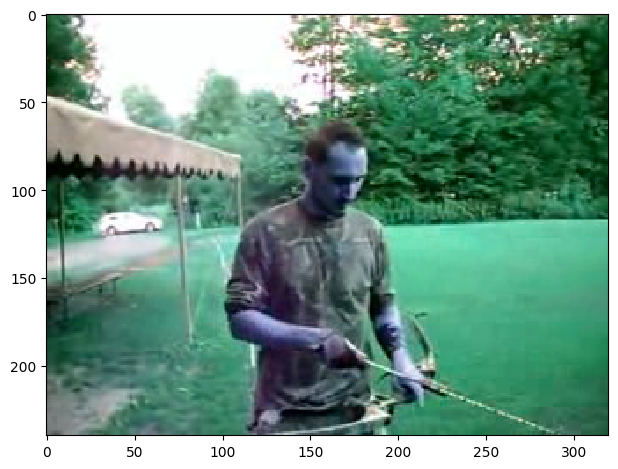

In [ ]:
random_snippet_segment_1.display_rgb_frame()

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


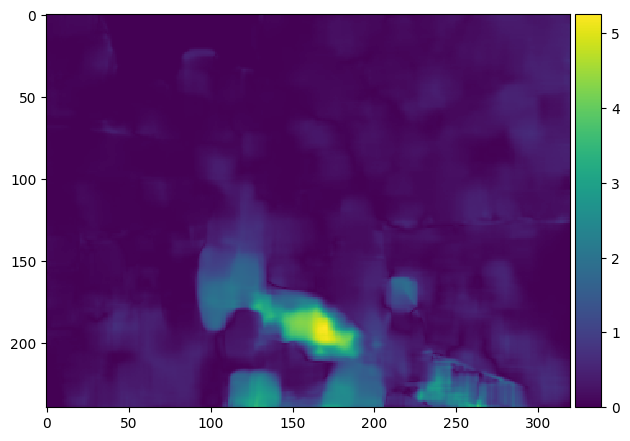

In [ ]:
random_snippet_segment_1.display_optical_flow_frame()

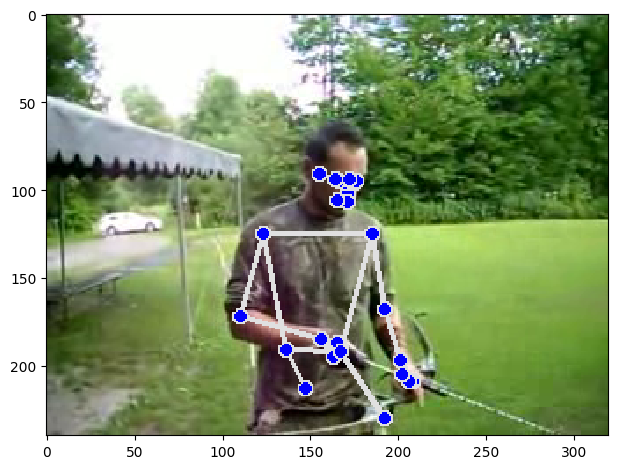

In [ ]:
random_snippet_segment_1.display_body_pose_frame()

Segment 2's random snippet:

Segment 3's random snippet:

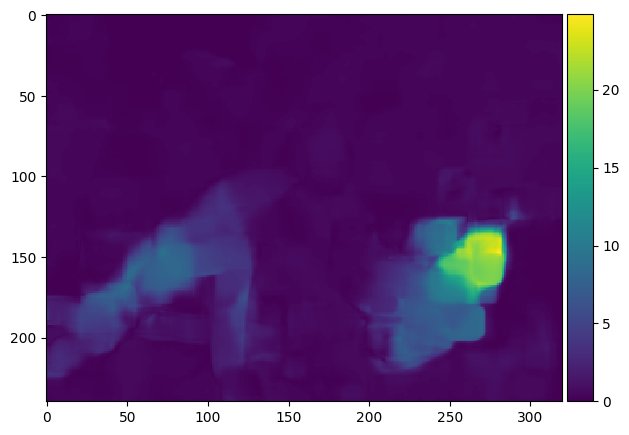

In [ ]:
video_1.segments[2].random_snippet.display_optical_flow_frame()